In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
#from environment.single_family_home import SingleFamilyHome

In [4]:
#env = SingleFamilyHome("./environment/configs/config_hourly.json")
#env.reset()

({'carbon_intensity': array([40.17], dtype=float32),
  'timestep': array([0.], dtype=float32),
  'co2_emitted': array([0.], dtype=float32),
  'energy_storage_system_charge': array([0.], dtype=float32),
  'flexible_demand_schedule': array([6.6780605], dtype=float32),
  'tcl_indoor_temperature': array([20.], dtype=float32)},
 {})

# Static Components Figure

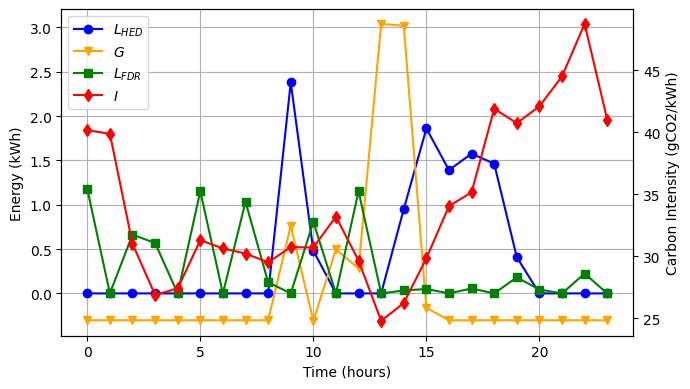

In [8]:

fig, ax = plt.subplots(figsize=(7, 4))
line1, = ax.plot(env.hed.episode.values[:24], label=r"$L_{HED}$", marker='o', color='blue')
line2, = ax.plot(env.rsa.episode.values[:24], label=r"$G$", marker='v', color='orange')
line3, = ax.plot(env.fdr.episode.values[:24], label=r"$L_{FDR}$", marker='s', color='green')
ax2 = ax.twinx()
line4, = ax2.plot(env.ees.episode.values[:24], label="$I$", marker='d', color='red')

# Create a list of lines and labels
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]

# Create the legend box
ax.legend(lines, labels, loc='upper left')

# Set labels for the x and y axes
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Energy (kWh)')
ax2.set_ylabel('Carbon Intensity (gCO2/kWh)')


# Add a grid to the plot
ax.grid(True)

# Adjust subplot parameters
plt.tight_layout()

# Show the plot
plt.show()

# Idle reward

In [8]:
import numpy as np
from analysis import load_data
data_dict = load_data("./logs/hourly")["idle"]

data_dict["cache"].keys()

dict_keys(['given_reward', 'battery_reward', 'fdr_reward', 'tcl_reward', 'discomfort'])

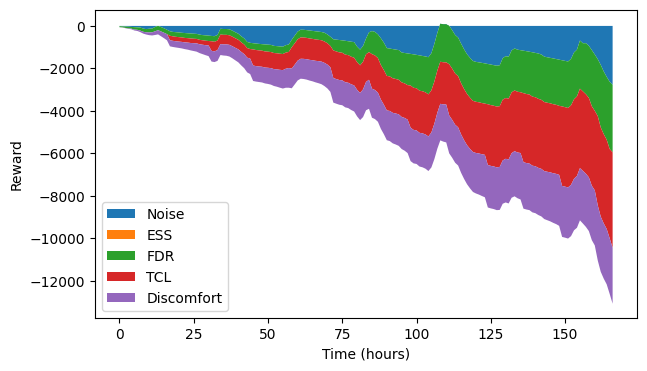

In [24]:
keys = list(data_dict["cache"].keys())
lists = [np.cumsum(data_dict["cache"][key]) for key in keys]

fig, ax = plt.subplots(figsize=(7, 4))
ax.stackplot(range(len(lists[0])), lists, labels=['Noise', 'ESS', 'FDR', 'TCL', 'Discomfort'])

ax.legend(loc='lower left')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Reward')

plt.show()

# Initial training curve

In [3]:
from analysis import *

In [4]:
data_dict = load_data("./logs/hourly")

In [7]:
data_dict_initial = {
    "idle": data_dict["idle"],
    "single-threshold": data_dict["single-threshold"],
    "ppo": data_dict["ppo"],
    "sac": data_dict["sac"],
}

In [8]:
results = load_results("./logs/hourly")

In [9]:
results_initial = {
    "idle": results["idle"],
    "single-threshold": results["single-threshold"],
    "ppo": results["ppo"],
    "sac": results["sac"],
}

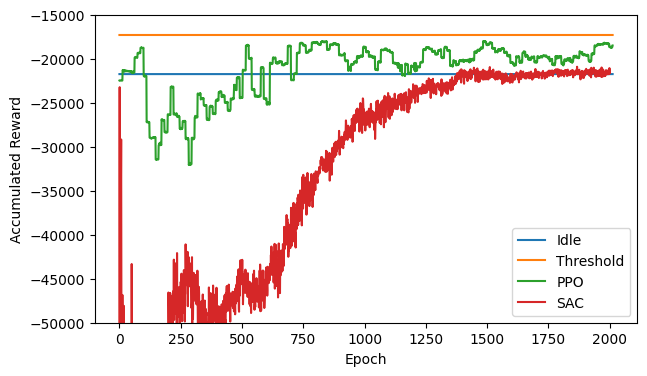

In [23]:
cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0, 0.9, len(results_initial)))
plt.figure(figsize=(7,4))
ax = plt.gca()

labels = ["Idle", "Threshold", "PPO", "SAC"]

for i, run in enumerate(results_initial.keys()):
    if len(results_initial[run]) > 1:
        data = np.array(results_initial[run])
    else:
        data = results_initial[run] * np.max([len(eps) for eps in results_initial.values()])
    ax.plot(data, label=labels[i])#, color=colors[i])

ax.legend()
ax.set_ylabel("Accumulated Reward")
ax.set_xlabel("Epoch")
ax.set_ylim([-50000, -15000])
#ax.grid()

plt.show()

# Table

## Hypo 2/3

In [37]:
ess_results = load_results("./logs/ess")
fdr_results = load_results("./logs/fdr")
tcl_results = load_results("./logs/tcl")
hourly_results = load_results("./logs/hourly")

In [34]:
for name, run in ess_results.items():
    print(name)
    print(np.max(run))
    print(np.argmax(run))

idle_hypo2
0.0
0
idle_hypo3
0.0
0
ppo_hypo2
488.577922
0
ppo_hypo3
650.489992
159
sac_hypo2
157.936341
0
sac_hypo3
599.653064
160
single-threshold_hypo2
633.239042
0
single-threshold_hypo3
633.239042
0


In [33]:
for name, run in fdr_results.items():
    print(name)
    print(np.max(run))
    print(np.argmax(run))

idle_hypo2
-3173.557718
0
idle_hypo3
-3173.557718
0
ppo_hypo2
-3035.301035
7
ppo_hypo3
-3170.043907
55
sac_hypo2
-2969.783256
60
sac_hypo3
-2969.362445
104
single-threshold_hypo2
-3068.557814
0
single-threshold_hypo3
-3068.557814
0


In [35]:
tcl_data = load_data("./logs/tcl")
hourly_data = load_data("./logs/hourly")

In [99]:
indices = {}
for name, run in hourly_results.items():
    print(name)
    print(np.max(run))
    print(np.argmax(run))
    indices[name] = np.argmax(run)

idle_full
-21746.737545
0
idle_hypo1
-21746.737545
0
ppo_full
-18962.034530666664
53
ppo_hypo1
-18788.411717
73
sac_full
-24143.000260999997
251
sac_hypo1
-23244.536347
1
single-threshold_full
-20712.681382
0
single-threshold_hypo1
-20722.547853
0


In [100]:
for name, info in hourly_data.items():
    episode = indices[name]
    if episode == 0:
        battery_reward = np.sum(np.array(info["cache"].get("battery_reward", np.zeros(168))[:167]))
        fdr_reward = np.sum(np.array(info["cache"].get("fdr_reward", np.zeros(168))[:167]))
        tcl_reward = np.sum(np.array(info["cache"].get("tcl_reward", np.zeros(168))[:167]))
        discomfort = -np.sum(5 * np.exp(np.sqrt(np.abs(info["cache"]["discomfort"][:167])/5)))
    else:
        battery_reward = np.sum(np.array(info["cache"].get("battery_reward", np.zeros(167))[-167*episode:-167*(episode+1)]))
        fdr_reward = np.sum(np.array(info["cache"].get("fdr_reward", np.zeros(167))[-167*episode:-167*(episode+1)]))
        tcl_reward = np.sum(np.array(info["cache"].get("tcl_reward", np.zeros(167))[-167*episode:-167*(episode+1)]))
        discomfort = -np.sum(5 * np.exp(np.sqrt(np.abs(info["cache"]["discomfort"][-167*episode:-167*(episode+1)])/5)))
    print(name)
    print(tcl_reward+discomfort+battery_reward+fdr_reward)
    print(battery_reward)
    print(fdr_reward)
    print(tcl_reward)
    print(discomfort)

sac_hypo1
0.0
0.0
0.0
0.0
-0.0
ppo_hypo1
0.0
0.0
0.0
0.0
-0.0
ppo_full
0.0
0.0
0.0
0.0
-0.0
sac_full
0.0
0.0
0.0
0.0
-0.0
idle_full
-18973.804964811134
0.0
-3173.557717524562
-9887.614471258334
-5912.632776028236
idle_hypo1
-18973.804964811134
0.0
-3173.557717524562
-9887.614471258334
-5912.632776028236
single-threshold_hypo1
-17949.615272098014
633.2390415192237
-3068.5578143732796
-9957.066349774012
-5557.230149469948
single-threshold_full
-17952.402501497374
633.2390415192237
-3071.345043772637
-9957.066349774012
-5557.230149469948


In [39]:
indices = {}
for name, run in tcl_results.items():
    print(name)
    print(np.max(run))
    print(np.argmax(run))
    indices[name] = np.argmax(run)

idle_hypo2
-15800.247247
0
idle_hypo3
-15800.247247
0
ppo_hypo2
-13907.674131
20
ppo_hypo3
-16426.014236
0
sac_hypo2
-15021.164434
1
sac_hypo3
-66136.71521
233
single-threshold_hypo2
-15514.296499
0
single-threshold_hypo3
-15514.296499
0


In [78]:
for name, info in tcl_data.items():
    episode = indices[name]
    if episode == 0:
        tcl_reward = np.sum(np.array(info["cache"].get("tcl_reward", np.zeros(168))[:167]))
        discomfort = -np.sum(5 * np.exp(np.sqrt(np.abs(info["cache"]["discomfort"][:167])/5)))
    else:
        tcl_reward = np.sum(np.array(info["cache"].get("tcl_reward", np.zeros(167))[-167*episode:-167*(episode+1)]))
        discomfort = -np.sum(5 * np.exp(np.sqrt(np.abs(info["cache"]["discomfort"][-167*episode:-167*(episode+1)])/5)))
    print(name)
    print(tcl_reward+discomfort)
    print(tcl_reward)
    print(discomfort)

sac_hypo3
-97083.32752247396
-53477.14174749851
-43606.185774975456
sac_hypo2
-41370.70653461755
-33766.60053971708
-7604.1059949004675
ppo_hypo3
-54338.35671848837
-40540.6841118
-13797.672606688373
idle_hypo2
-15800.24724728657
-9887.614471258334
-5912.632776028236
ppo_hypo2
-42488.74749004037
-34874.90036735982
-7613.847122680551
idle_hypo3
-15800.24724728657
-9887.614471258334
-5912.632776028236
single-threshold_hypo3
-15514.29649924396
-9957.066349774012
-5557.230149469948
single-threshold_hypo2
-15514.29649924396
-9957.066349774012
-5557.230149469948


In [79]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from src.environment.single_family_home import SingleFamilyHome
from utils import LoggingCallback
from stable_baselines3 import SAC, PPO

In [83]:
ppo_hypo2 = PPO.load("./models/tcl/ppo_hypo2/best_model.zip")
ppo_hypo3 = PPO.load("./models/tcl/ppo_hypo3/best_model.zip")
sac_hypo2 = SAC.load("./models/tcl/sac_hypo2/best_model.zip")
sac_hypo3 = SAC.load("./models/tcl/sac_hypo3/best_model.zip")

In [84]:
def strip_infos(infos):
    return {
        key: {key_inner: [info[key][key_inner] for info in infos] for key_inner in
              infos[0][key].keys()}
        if isinstance(infos[0][key], dict)
        else [info[key] for info in infos]
        for key in infos[0].keys()
    }

In [93]:
env = Monitor(SingleFamilyHome("./environment/configs/config_tcl.json"))
logging = LoggingCallback()
evaluate_policy(ppo_hypo2, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

-10755.647661904995
-3152.0264691010093


In [94]:
env = Monitor(SingleFamilyHome("./environment/configs/config_tcl.json"))
logging = LoggingCallback()
evaluate_policy(sac_hypo2, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

-10114.508170881307
-4906.656262980938


In [95]:
env = Monitor(SingleFamilyHome("./environment/configs/config_tcl.json"))
logging = LoggingCallback()
evaluate_policy(ppo_hypo3, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

-10512.148970667204
-5913.8652653269355


In [96]:
env = Monitor(SingleFamilyHome("./environment/configs/config_tcl.json"))
logging = LoggingCallback()
evaluate_policy(sac_hypo3, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

-52971.75813154
-13164.957078248272


In [102]:
ppo_full = PPO.load("./models/hourly/ppo_full/best_model.zip")
ppo_hypo1 = PPO.load("./models/hourly/ppo_hypo1/best_model.zip")
sac_full = SAC.load("./models/hourly/sac_full/best_model.zip")
sac_hypo1 = SAC.load("./models/hourly/sac_hypo1/best_model.zip")

In [119]:
from environment.single_family_home_full import SingleFamilyHome
env = Monitor(SingleFamilyHome("./environment/configs/config_hourly.json"))
logging = LoggingCallback()
evaluate_policy(ppo_full, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["battery_reward"]))
print(np.sum(infos["cache"]["fdr_reward"]))
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

0.0
-3155.3900753157477
-10824.214492085172
-792.6322975268115


In [109]:
from environment.single_family_home_full import SingleFamilyHome
env = Monitor(SingleFamilyHome("./environment/configs/config_hourly.json"))
logging = LoggingCallback()
evaluate_policy(sac_full, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["battery_reward"]))
print(np.sum(infos["cache"]["fdr_reward"]))
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

60.23531600267296
-3087.390544055752
-14692.595549196089
-1637.0076237884532


In [111]:
from environment.single_family_home_hypo1 import SingleFamilyHome
env = Monitor(SingleFamilyHome("./environment/configs/config_hourly.json"))
logging = LoggingCallback()
evaluate_policy(ppo_hypo1, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["battery_reward"]))
print(np.sum(infos["cache"]["fdr_reward"]))
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

0.0
-3151.343864881611
-11058.749127034484
-531.888568107466


In [112]:
from environment.single_family_home_hypo1 import SingleFamilyHome
env = Monitor(SingleFamilyHome("./environment/configs/config_hourly.json"))
logging = LoggingCallback()
evaluate_policy(sac_hypo1, env, callback=logging, n_eval_episodes=1)
infos = strip_infos(logging.infos)
print(np.sum(infos["cache"]["battery_reward"]))
print(np.sum(infos["cache"]["fdr_reward"]))
print(np.sum(infos["cache"]["tcl_reward"]))
print(np.sum(infos["cache"]["discomfort"]))

-40.177829162320165
-3192.114275962287
-14329.954054979398
-1258.5951021914498


# Learning curve full

In [124]:
from analysis import load_results

In [126]:
runs = load_results("./logs/hourly")

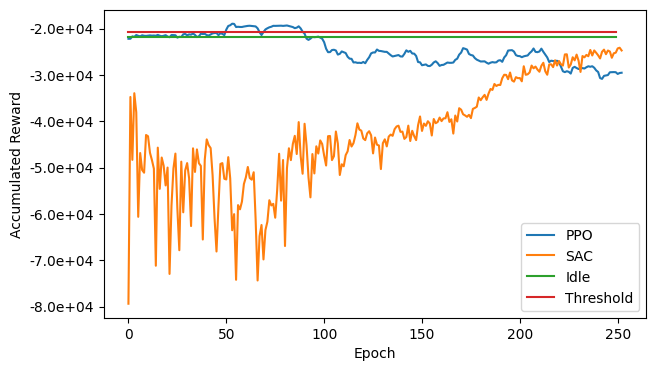

In [137]:
plt.figure(figsize=(7,4))
ax = plt.gca()

ax.plot(runs["ppo_full"], label="PPO")
ax.plot(runs["sac_full"], label="SAC")
ax.plot([runs["idle_full"][0]]*250, label="Idle")
ax.plot([runs["single-threshold_full"][0]]*250, label="Threshold")

ax.legend()
ax.set_ylabel("Accumulated Reward")
ax.set_xlabel("Epoch")

plt.show()

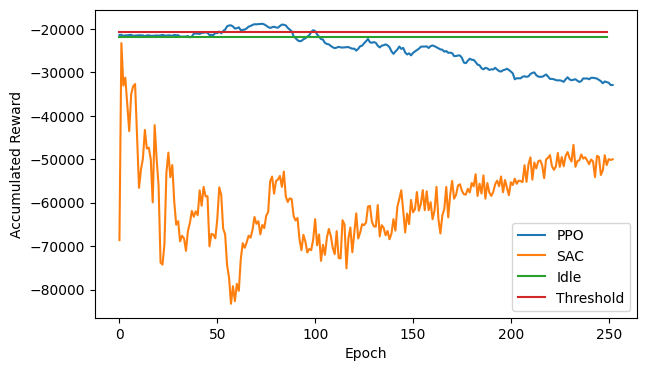

In [138]:
plt.figure(figsize=(7,4))
ax = plt.gca()

ax.plot(runs["ppo_hypo1"], label="PPO")
ax.plot(runs["sac_hypo1"], label="SAC")
ax.plot([runs["idle_hypo1"][0]]*250, label="Idle")
ax.plot([runs["single-threshold_hypo1"][0]]*250, label="Threshold")

ax.legend()
ax.set_ylabel("Accumulated Reward")
ax.set_xlabel("Epoch")

plt.show()

In [ ]:
plt.figure(figsize=(7,4))
ax = plt.gca()

ax.plot(runs["ppo_hypo1"], label="PPO")
ax.plot(runs["sac_hypo1"], label="SAC")
ax.plot([runs["idle_hypo1"][0]]*250, label="Idle")
ax.plot([runs["single-threshold_hypo1"][0]]*250, label="Threshold")

ax.legend()
ax.set_ylabel("Accumulated Reward")
ax.set_xlabel("Epoch")

plt.show()

In [139]:
runs_ess = load_results("./logs/ess")
runs_fdr = load_results("./logs/fdr")
runs_tcl = load_results("./logs/tcl")

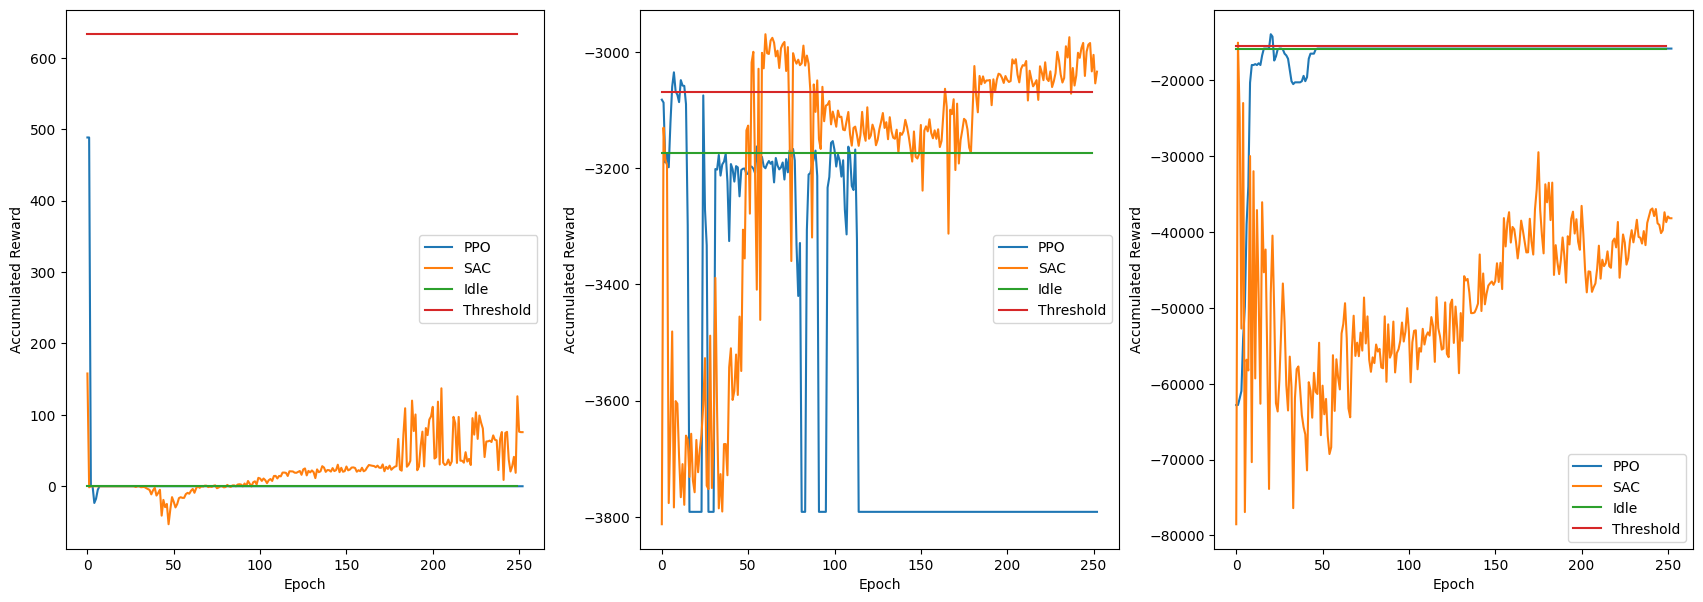

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

for i, data in enumerate([runs_ess, runs_fdr, runs_tcl]):
    ax[i].plot(data["ppo_hypo2"], label="PPO")
    ax[i].plot(data["sac_hypo2"], label="SAC")
    ax[i].plot([data["idle_hypo2"][0]]*250, label="Idle")
    ax[i].plot([data["single-threshold_hypo2"][0]]*250, label="Threshold")

    ax[i].legend()
    ax[i].set_ylabel("Accumulated Reward")
    ax[i].set_xlabel("Epoch")

plt.show()

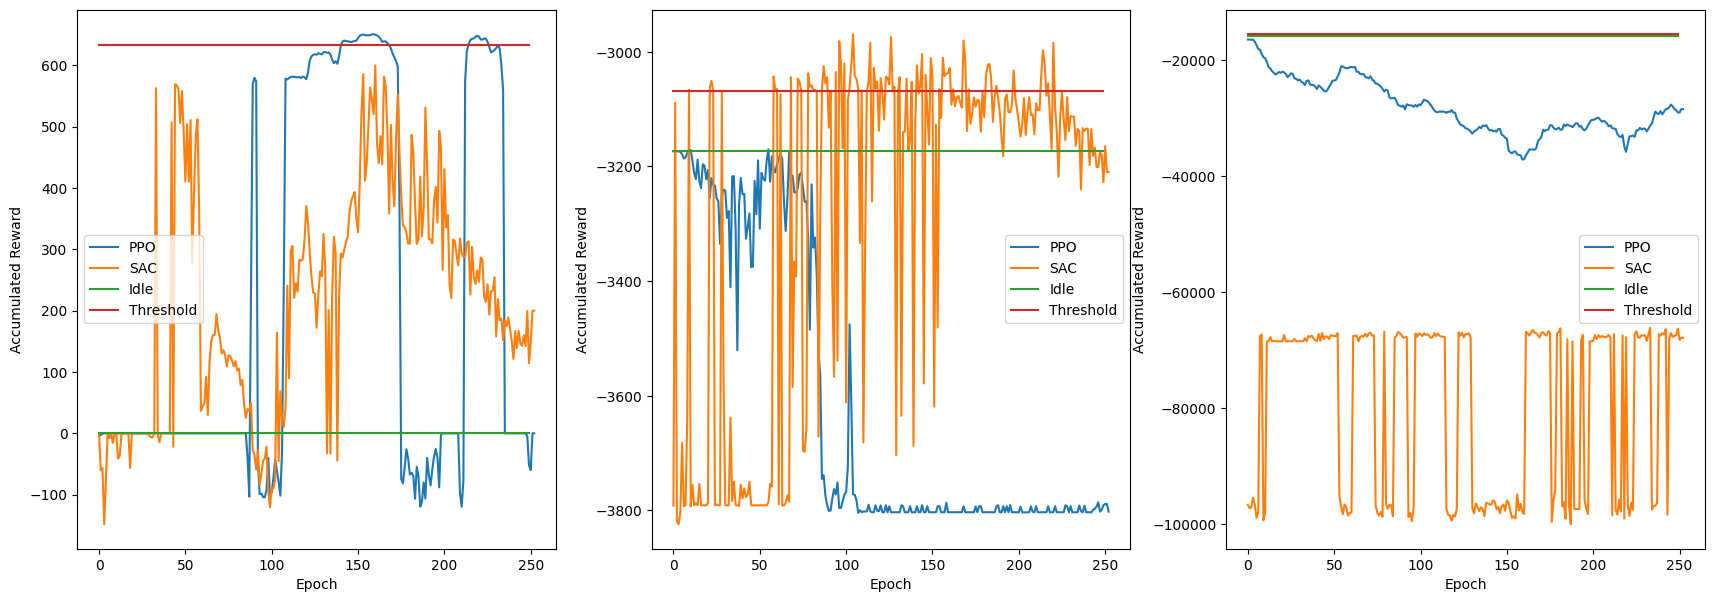

In [142]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

for i, data in enumerate([runs_ess, runs_fdr, runs_tcl]):
    ax[i].plot(data["ppo_hypo3"], label="PPO")
    ax[i].plot(data["sac_hypo3"], label="SAC")
    ax[i].plot([data["idle_hypo3"][0]]*250, label="Idle")
    ax[i].plot([data["single-threshold_hypo3"][0]]*250, label="Threshold")

    ax[i].legend()
    ax[i].set_ylabel("Accumulated Reward")
    ax[i].set_xlabel("Epoch")

plt.show()